# Russian wikipedia parsing and network compiling 

### In this script You can find 2 classes:
- WikiObject - class for wikipedia page request and extracting all links from the body of the document
- WikiWalker - class for for composing a directed graph by randomly clicking on links from a set of collected links at previous step

In [2]:
import requests
import random
import pickle
import time
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

import networkx as nx
import numpy as np

from bs4 import BeautifulSoup

from IPython.display import clear_output

In [3]:
class WikiObject():
    
    def __init__(self, link):
        self.link = link
        self.status = False
        
    def get_html(self):
        try:
            response = requests.get(self.link)
            self.status = response.ok
            return response.text if response.ok else None
        except:
            self.status = False
            return None


    def get_title(self, soup):
        return ' '.join(soup.find('title').text.split())    

    def find_all_links(self, soup):
        main_content = soup.find('div', {'id' : 'bodyContent', 'class' : 'vector-body'})
        links = []
        for a_tag in main_content.find_all('a'):
            try:
                link = a_tag['href']
                if re.search('\/wiki\/', link) and not re.search('\.', link.split('/wiki/')[-1]):
                    links.append(link)
            except KeyError as e:
                pass
        
        return set(map(lambda link: 'https://ru.wikipedia.org' + link, links))
        
    def extract_info(self):
        html = self.get_html()
        if self.status:
            soup = BeautifulSoup(html)
            self.name = self.get_title(soup)
            self.neighbor_links = self.find_all_links(soup)
            return self.status, self.name, self.neighbor_links
        return self.status, '?', '?'

In [14]:
class WikiWalker():
    
    def __init__(self, checkpoints, name='WIKI', path='Saved_Graphs'):
        self.G = nx.DiGraph()
        self.free_links = set()
        self.busy_links = set()
        self.bad_links  = set()
        self.connections = 0
        self.checkpoints = checkpoints
        self.name = name
        self.path = path
 
    def add_new_edges(self, current_link):
        for link in self.busy_links:
            # IN edges
            if current_link in self.G.nodes[link]['neighbor_links']:
                self.G.add_edge(link, current_link)
                self.G.nodes[link]['neighbor_links'].difference_update(current_link)
                self.connections += 1
            # OUT edges
            if link in self.G.nodes[current_link]['neighbor_links']:
                self.G.add_edge(current_link, link)
                self.G.nodes[current_link]['neighbor_links'].difference_update(link)
                self.connections += 1
                
    def name_checker(self, name):
        return not(bool(re.search('шаблон', name, re.IGNORECASE)) |\
                   bool(re.search('категория', name, re.IGNORECASE)) |\
                   bool(re.search('категории', name, re.IGNORECASE)))

    def random_walking(self, current_link='https://ru.wikipedia.org/', num_of_nodes=100):
        while True:
            start_time = time.time_ns()
            wiki_page = WikiObject(current_link)
            status, name, links = wiki_page.extract_info()
            
            if status and self.name_checker(name):
                # Add new node
                self.G.add_node(node_for_adding=current_link, name=name, neighbor_links=links)
                
                # Add new edges for current node (link)
                # Here we find all edges (links) between already existing pages and current page
                self.add_new_edges(current_link)
                
                # Update sets of links
                self.busy_links.add(current_link)
                self.free_links = self.free_links.union(links)
                self.free_links.difference_update(current_link)
                
                # Output of current state
                self.verboser(current_link=current_link, start_time=start_time, clear=True)
                
                # Random selection of the next free link
                current_link = random.choice(list(self.free_links))                
                
                # Saving our graph
                if len(self.G.nodes) in self.checkpoints: self.save_graph()
                
            else:
                # Remove bad links
                self.bad_links.add(current_link)
                self.free_links.difference_update(current_link)

                # Random selection of the next free link
                current_link = random.choice(list(self.free_links))
                
            if not self.free_links or len(self.G.nodes) >= num_of_nodes: break
        self.save_graph()
                
    def verboser(self, current_link, start_time, clear=True):
        page_name = self.G.nodes[current_link]['name']
        end_time = time.time_ns()
        time_total = round((end_time - start_time)/10**9, 3)
        print(f'Page: {page_name}')
        print(f'Link: {current_link}')        
        print(f'Links added: {len(self.G.nodes)}')
        print(f'Edges_added: {len(self.G.edges)}')
        print(f'Free links: {len(self.free_links)}')
        print(f'Time for page: {time_total}')
        print('-'*50)
        if clear: clear_output(True)
        
    def save_graph(self):
        save_path = './' + '/'.join((self.path, '_'.join((self.name, str(len(self.G.nodes))))))
        with open(f'{save_path}.pkl', 'wb') as f:
            pickle.dump(self.G, f)

In [17]:
# Checkpoints to save gpaph each N steps
N = 500
CHECKPOINTS = [i for i in range(0, 50001, N)][1:]

w = WikiWalker(CHECKPOINTS)

In [22]:
LINK = 'https://ru.wikipedia.org/wiki/PageRank'
NUM_NODES = 50

w.random_walking(current_link=LINK, num_of_nodes=NUM_NODES)

Page: Воклен, Луи Никола — Википедия
Link: https://ru.wikipedia.org/wiki/%D0%92%D0%BE%D0%BA%D0%BB%D0%B5%D0%BD,_%D0%9B%D1%83%D0%B8_%D0%9D%D0%B8%D0%BA%D0%BE%D0%BB%D0%B0
Links added: 50
Edges_added: 147
Free links: 6418
Time for page: 1.573
--------------------------------------------------


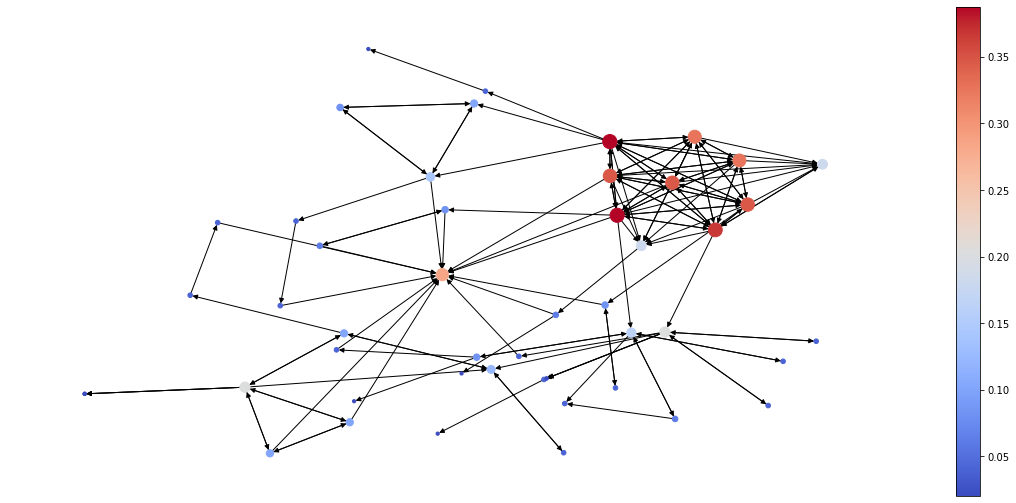

In [24]:
plt.figure(figsize=(20,9))

deg_centrality = nx.degree_centrality(w.G)
cent = np.fromiter(deg_centrality.values(), float)
sizes = cent / np.max(cent) * 200
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.coolwarm

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(cent)
plt.colorbar(scalarmappaple)

pos = nx.kamada_kawai_layout(w.G)
nx.draw(w.G, pos, node_size=sizes, node_color=sizes, cmap=colormap)
plt.show()